* This notebook was made to look at when currents from cold start could catch up with nowcasts, so that I can determine how many days before that I could run a simulation use TS initial file rather than restart file, to do the hindcast of Oct8-10, 2014. Is 1 day before that enough to catch the UV velocity with nowcasts? The answer will be explored in this notebook.

In [1]:
from __future__ import division, print_function

from cStringIO import StringIO
from salishsea_tools import (
    nc_tools,
    viz_tools,
    stormtools,
    tidetools,
)
from glob import glob
from salishsea_tools.nowcast import figures
from matplotlib import pylab
from dateutil import tz
from matplotlib.backends import backend_agg as backend
from scipy import interpolate as interp
from matplotlib import animation
import scipy.io as sio
import datetime
import os
import arrow
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import netCDF4 as nc
import numpy as np
import pandas as pd
import requests

In [2]:
%matplotlib inline

* I will check out velocity of new simulation during June 15-29 at Sandheads and compare it with nowcasts.

In [3]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'i' : 77,##426 start from 349 fortran start from 350
        'j' : 34,##293 start from 259 fortran start from 260
    },
    }
# Font format
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '20', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '18'}

* For June 15

In [4]:
grid_T_15 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/15jun15/SalishSea_1h_20150615_20150615_grid_T.nc')

In [5]:
grid_U_new15 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/24nor_NW/15jun15/SalishSea_1h_20150615_20150615_grid_U.nc')
grid_V_new15 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/24nor_NW/15jun15/SalishSea_1h_20150615_20150615_grid_V.nc')

In [6]:
u_15new = grid_U_new15.variables['vozocrtx']
v_15new = grid_V_new15.variables['vomecrty']

In [7]:
grid_U_15 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/15jun15/SalishSea_1h_20150615_20150615_grid_U.nc')
grid_V_15 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/15jun15/SalishSea_1h_20150615_20150615_grid_V.nc')

In [8]:
u_15now = grid_U_15.variables['vozocrtx']
v_15now = grid_V_15.variables['vomecrty']

In [21]:
def compare_surfacecurrent(grid_T, PST, u_15new, u_15now, v_15new, v_15now):
    '''This function was made to compare surface currents at Sandheads
        during a day'''
    ##some constant parameters
    time_shift = datetime.timedelta(hours=-8)
    t_orig, t_final, t = figures.get_model_time_variables(grid_T)
    start_date = t_orig.strftime('%d-%b-%Y')
    end_date = t_final.strftime('%d-%b-%Y')
    timezone = PST * '[PST]' + abs((PST - 1)) * '[UTC]'
    fig, axs = plt.subplots(2, 1, figsize=(15, 8))
    names = ['Sandheads']
    #lims = [-1.5,1]
    u = [u_15new, u_15now]
    v = [v_15new, v_15now]
    labels = ['new','nowcast']
    ax = axs[0]
    for uu, la in zip(u, labels):
        uuu= uu[:, 0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259]
        ax.plot(t,uuu,linewidth=2, label = la)
        ax.grid('on')
        ax.set_ylim([-2,1.5])
        ax.set_title(
            'Hourly Surface Current at '+ names[0]+' :{t_orig:%d-%b-%Y}'
            .format( t_orig=t_orig),
            **title_font)
        ax.set_ylabel('zonal surface current u (m/s)', **axis_font)
        plt.setp(ax.get_xticklabels(), fontsize=12)
        plt.setp(ax.get_yticklabels(), fontsize=12)
        ax.legend(loc = 3)

    ax = axs[1]
    for vv, la in zip(v, labels):
        vvv =  vv[:,0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259]
        ax.plot(t,vvv,linewidth=2, label= la)
        ax.grid('on')
        #x.set_xlim([0, 24])
        #icks = range(24)
        #x.set_xticks(ticks, minor = False)
        #x.set_xticklabels(ticks)
        ax.set_ylim([-2,1.5])
        ax.set_title(
            'Hourly Surface Current at '+ names[0]+' : {t_orig:%d-%b-%Y}'
                .format( t_orig=t_orig),
                **title_font)
        ax.set_ylabel('meridional surface current v (m/s)', **axis_font)
        ax.set_xlabel('Time hr {}'.format(timezone), **axis_font)
        plt.setp(ax.get_xticklabels(), fontsize=12)
        plt.setp(ax.get_yticklabels(), fontsize=12)
        ax.legend(loc = 3)
    return fig   

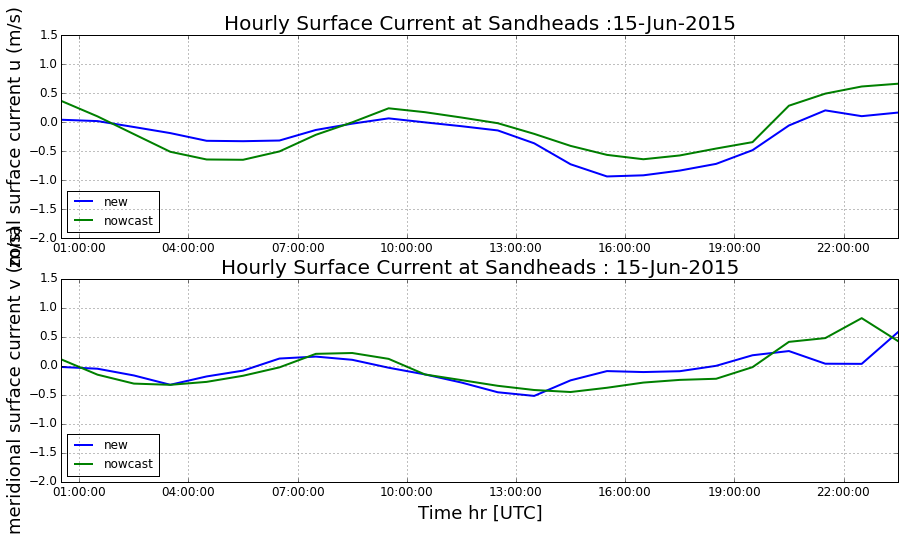

In [22]:
fig = compare_surfacecurrent(grid_T_15, 0, u_15new, u_15now, v_15new, v_15now)

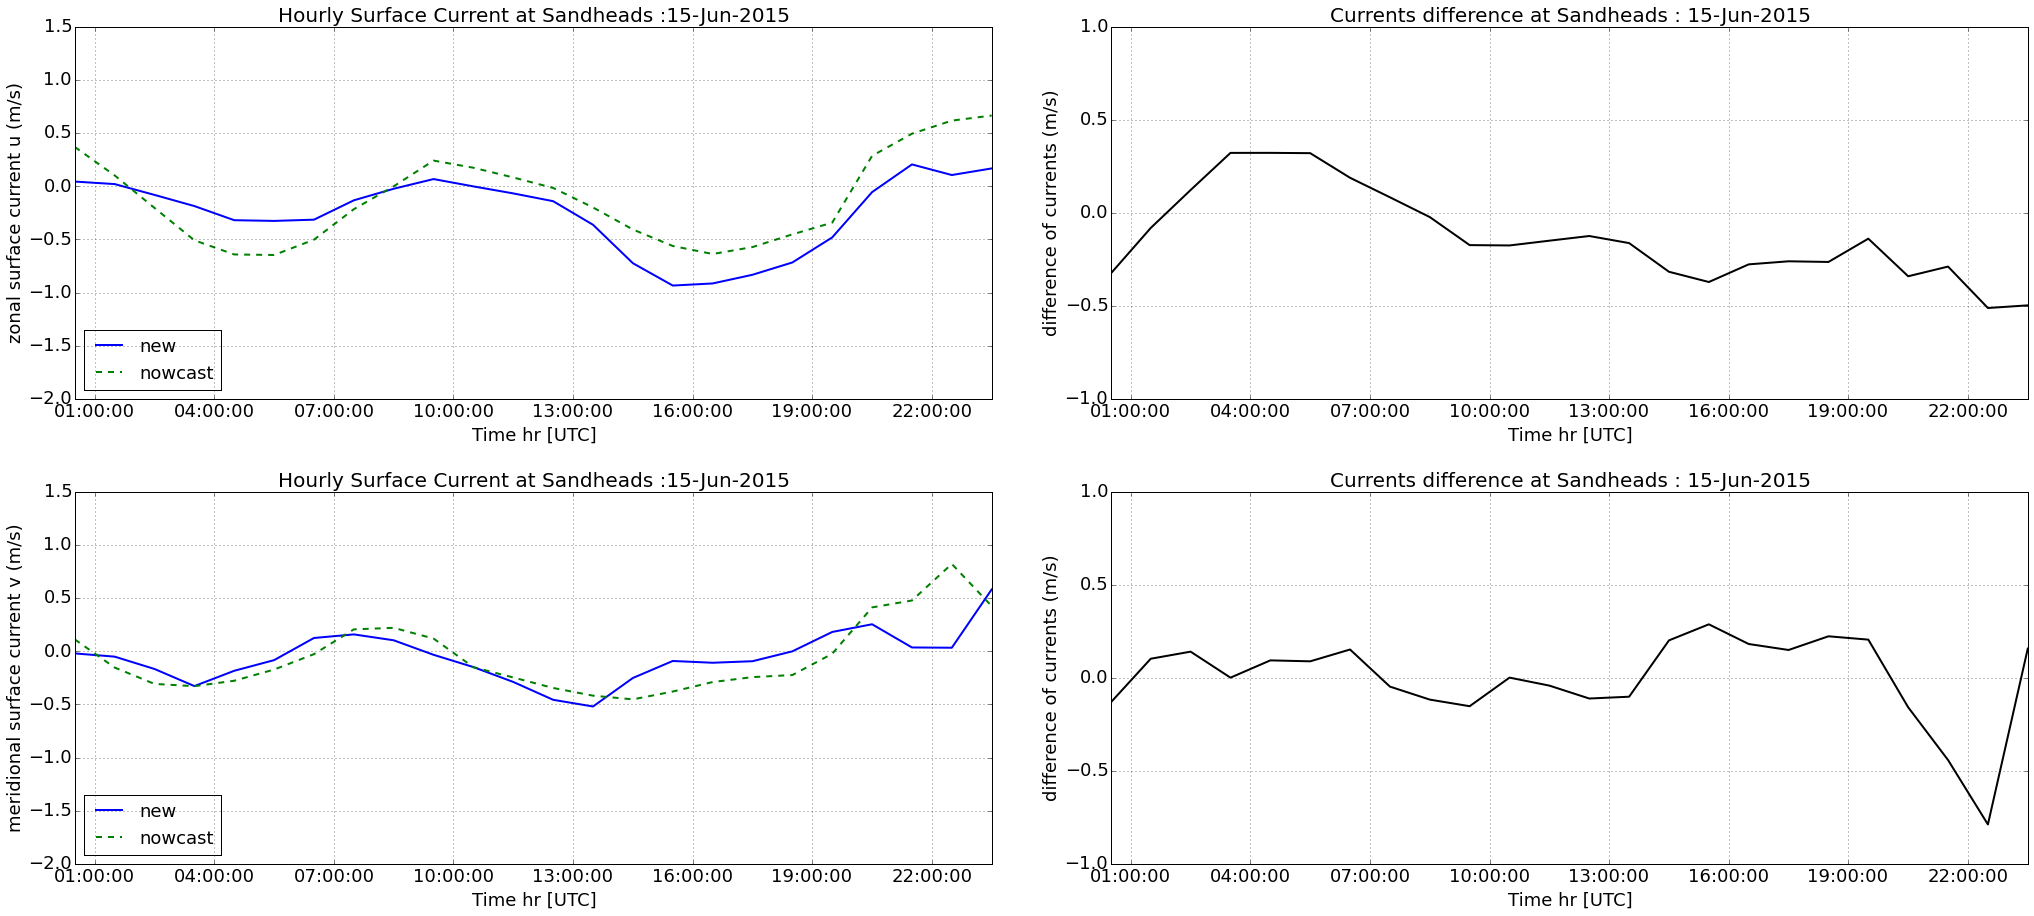

In [26]:
    PST = 0
    t_orig, t_final, t = figures.get_model_time_variables(grid_T_15)
    start_date = t_orig.strftime('%d-%b-%Y')
    end_date = t_final.strftime('%d-%b-%Y')
    timezone = PST * '[PST]' + abs((PST - 1)) * '[UTC]'
    #fig, axs = plt.subplots(2, 1, figsize=(15, 8))
    fig = plt.figure(figsize=(35,15))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])
    gs.update(wspace=0.13,hspace=0.25)
    ax0 = fig.add_subplot(gs[0, 0])  # U for new & nowcasts
    ax1 = fig.add_subplot(gs[1, 0])  # V for new & nowcasts
    ax2 = fig.add_subplot(gs[0, 1])  # difference for U
    ax3 = fig.add_subplot(gs[1, 1])  # difference for V
    axs = [ax0, ax1]
    axss = [ax2,ax3]
    names = ['Sandheads']
    uv_new = [u_15new, v_15new]
    uv_now = [u_15now, v_15now]
    labels = 'new'
    labelss = 'nowcast'
        
    for iuv, ax in zip(uv_new, axs):
        if t_orig.day < 16:
            ii =  iuv[:,0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259] 
        else:
            ii= iuv[:, 0, sites['Sandheads']['i'], sites['Sandheads']['j']]
        ax.plot(t,ii,linewidth=2, label = labels)
        ax.grid('on')
        ax.set_ylim([-2,1.5])
        ax.set_title(
            'Hourly Surface Current at '+ names[0]+' :{t_orig:%d-%b-%Y}'
            .format( t_orig=t_orig),
            **title_font)
        ax.set_xlabel('Time hr {}'.format(timezone), **axis_font)
        plt.setp(ax.get_xticklabels(), fontsize=18)
        plt.setp(ax.get_yticklabels(), fontsize=18)
        ax.legend(loc = 3,fontsize = 18)
    ax0.set_ylabel('zonal surface current u (m/s)', **axis_font)
    
    for juv, ax in zip(uv_now, axs): ## uv for nowcasts
        jj =  juv[:,0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259]
        ax.plot(t,jj,linestyle='--' ,linewidth=2, label= labelss)
        ax.grid('on')
        ax.legend(loc = 3, fontsize = 18)
    ax1.set_ylabel('meridional surface current v (m/s)', **axis_font)
    
    for new, now, ax in zip(uv_new, uv_now, axss):
        if t_orig.day < 16:
            ii =  new[:,0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259] -\
            now[:,0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259]
        else:
            ii= new[:, 0, sites['Sandheads']['i'], sites['Sandheads']['j']] -\
            now[:,0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259]
        ax.plot(t,ii,color = 'k',linewidth=2)
        ax.grid('on')
        ax.set_ylim([-1,1])
        ax.set_title(
            'Currents difference at '+ names[0]+' : {t_orig:%d-%b-%Y}'
                .format( t_orig=t_orig),
                **title_font)
        ax.set_xlabel('Time hr {}'.format(timezone), **axis_font)
        plt.setp(ax.get_xticklabels(), fontsize=18)
        plt.setp(ax.get_yticklabels(), fontsize=18)
        ax.set_ylabel('difference of currents (m/s)', **axis_font)  

In [27]:
def compare_surfacecurrent_new(grid_T, PST, u_15new, v_15new, u_15now, v_15now):
    '''This function was made to compare surface currents at Sandheads
        during a day'''
    ##some constant parameters
    time_shift = datetime.timedelta(hours=-8)
    t_orig, t_final, t = figures.get_model_time_variables(grid_T)
    start_date = t_orig.strftime('%d-%b-%Y')
    end_date = t_final.strftime('%d-%b-%Y')
    timezone = PST * '[PST]' + abs((PST - 1)) * '[UTC]'
    #fig, axs = plt.subplots(2, 1, figsize=(15, 8))
    fig = plt.figure(figsize=(35,15))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])
    gs.update(wspace=0.13,hspace=0.25)
    ax0 = fig.add_subplot(gs[0, 0])  # U for new & nowcasts
    ax1 = fig.add_subplot(gs[1, 0])  # V for new & nowcasts
    ax2 = fig.add_subplot(gs[0, 1])  # difference for U
    ax3 = fig.add_subplot(gs[1, 1])  # difference for V
    axs = [ax0, ax1]
    axss = [ax2,ax3]
    names = ['Sandheads']
    uv_new = [u_15new, v_15new]
    uv_now = [u_15now, v_15now]
    labels = 'new'
    labelss = 'nowcast'
    
    for iuv, ax in zip(uv_new, axs):
        if t_orig.day < 16:
            ii =  iuv[:,0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259] 
        else:
            ii= iuv[:, 0, sites['Sandheads']['i'], sites['Sandheads']['j']]
        ax.plot(t,ii,linewidth=2, label = labels)
        ax.grid('on')
        ax.set_ylim([-2,1.5])
        ax.set_title(
            'Hourly Surface Current at '+ names[0]+' :{t_orig:%d-%b-%Y}'
            .format( t_orig=t_orig),
            **title_font)
        ax.set_xlabel('Time hr {}'.format(timezone), **axis_font)
        plt.setp(ax.get_xticklabels(), fontsize=18)
        plt.setp(ax.get_yticklabels(), fontsize=18)
        ax.legend(loc = 3,fontsize = 18)
    ax0.set_ylabel('zonal surface current u (m/s)', **axis_font)

    #ax = axs[1]
    for juv, ax in zip(uv_now, axs): ## uv for nowcasts
        jj =  juv[:,0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259]
        ax.plot(t,jj,linestyle='--' ,linewidth=2, label= labelss)
        ax.grid('on')
        ax.legend(loc = 3, fontsize = 18)
    ax1.set_ylabel('meridional surface current v (m/s)', **axis_font)
    
    #ax = ax2
    for new, now, ax in zip(uv_new, uv_now, axss):
        if t_orig.day < 16:
            ii =  new[:,0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259] -\
            now[:,0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259]
        else:
            ii= new[:, 0, sites['Sandheads']['i'], sites['Sandheads']['j']] -\
            now[:,0, sites['Sandheads']['i'] + 349, sites['Sandheads']['j'] + 259]
        ax.plot(t,ii,color = 'k',linewidth=2)
        ax.grid('on')
        ax.set_ylim([-1,1])
        ax.set_title(
            'Currents difference at '+ names[0]+' : {t_orig:%d-%b-%Y}'
                .format( t_orig=t_orig),
                **title_font)
        ax.set_xlabel('Time hr {}'.format(timezone), **axis_font)
        plt.setp(ax.get_xticklabels(), fontsize=18)
        plt.setp(ax.get_yticklabels(), fontsize=18)
        ax.set_ylabel('difference of currents (m/s)', **axis_font)  
    
    return fig   

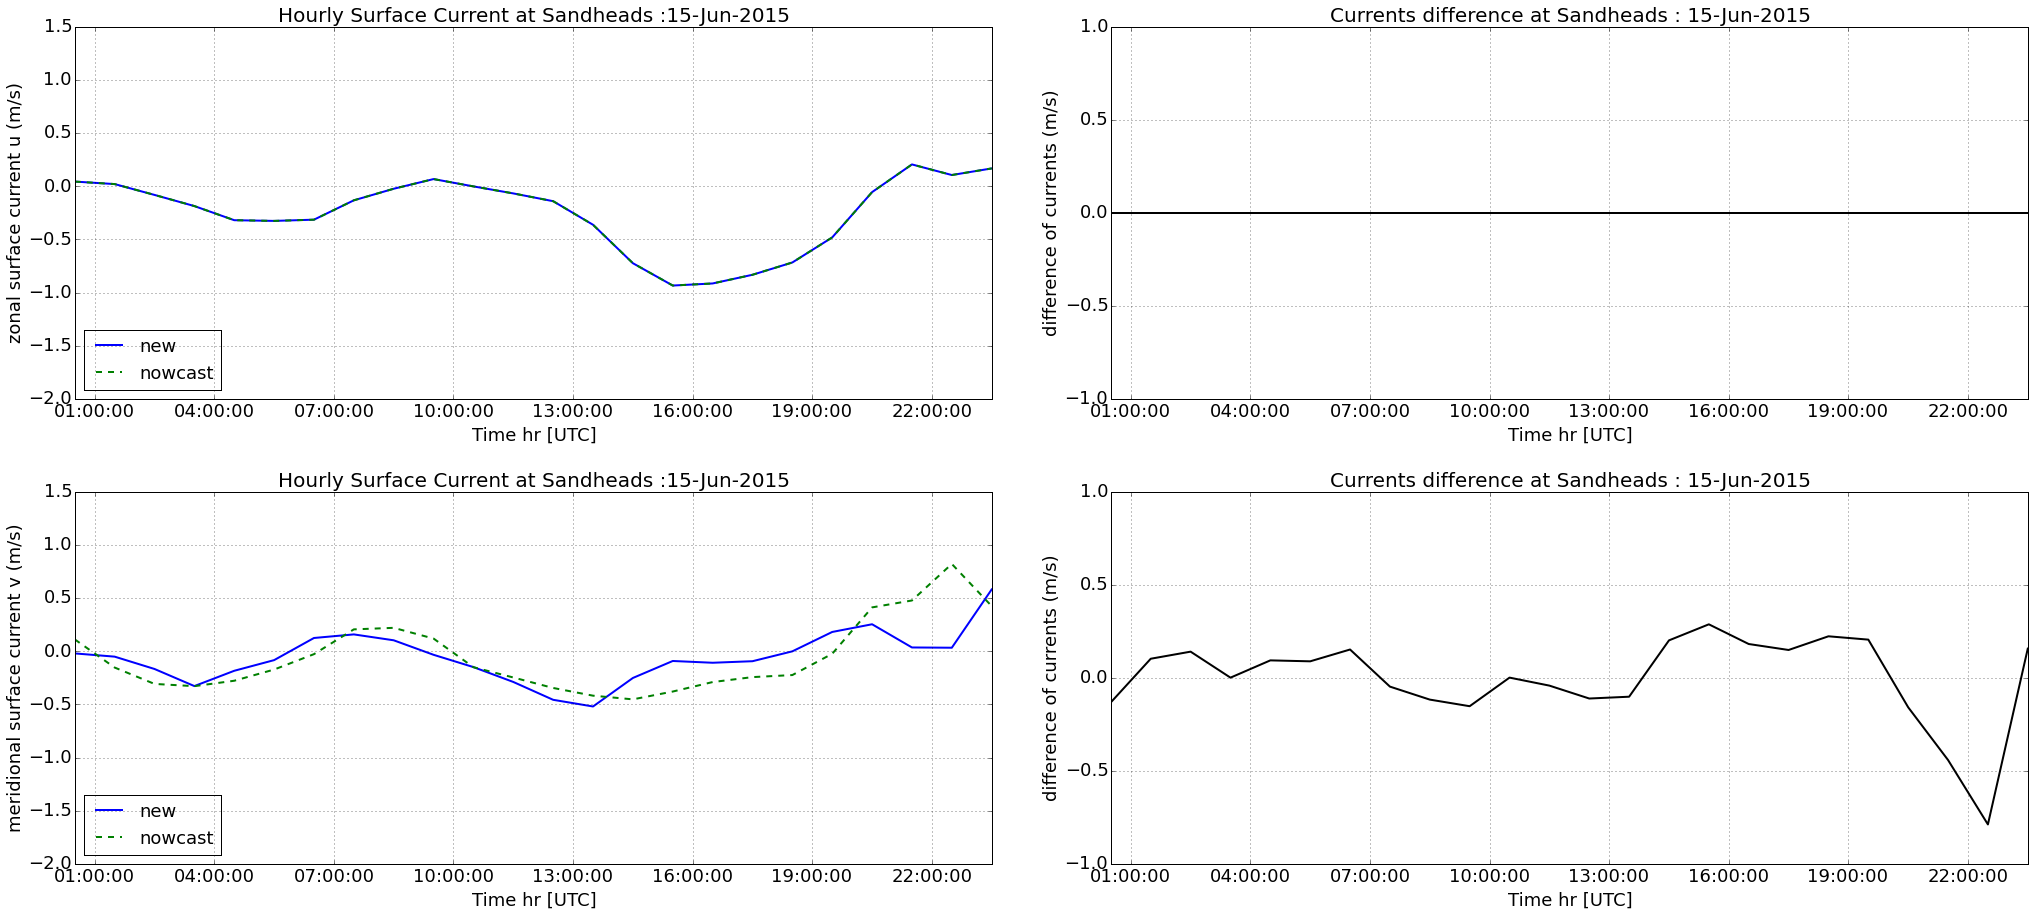

In [28]:
fig = compare_surfacecurrent_new(grid_T_15,0, u_15new, v_15new, u_15new, v_15now)

* For June 16 

In [13]:
grid_T_16 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/16jun15/SalishSea_1h_20150616_20150616_grid_T.nc')

In [14]:
grid_U_new16 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150616_20150616_grid_U.nc')
grid_V_new16 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150616_20150616_grid_V.nc')

In [15]:
u_16new = grid_U_new16.variables['vozocrtx']
v_16new = grid_V_new16.variables['vomecrty']

In [16]:
grid_U_16 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/16jun15/SalishSea_1h_20150616_20150616_grid_U.nc')
grid_V_16 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/16jun15/SalishSea_1h_20150616_20150616_grid_V.nc')

In [17]:
u_16now = grid_U_16.variables['vozocrtx']
v_16now = grid_V_16.variables['vomecrty']

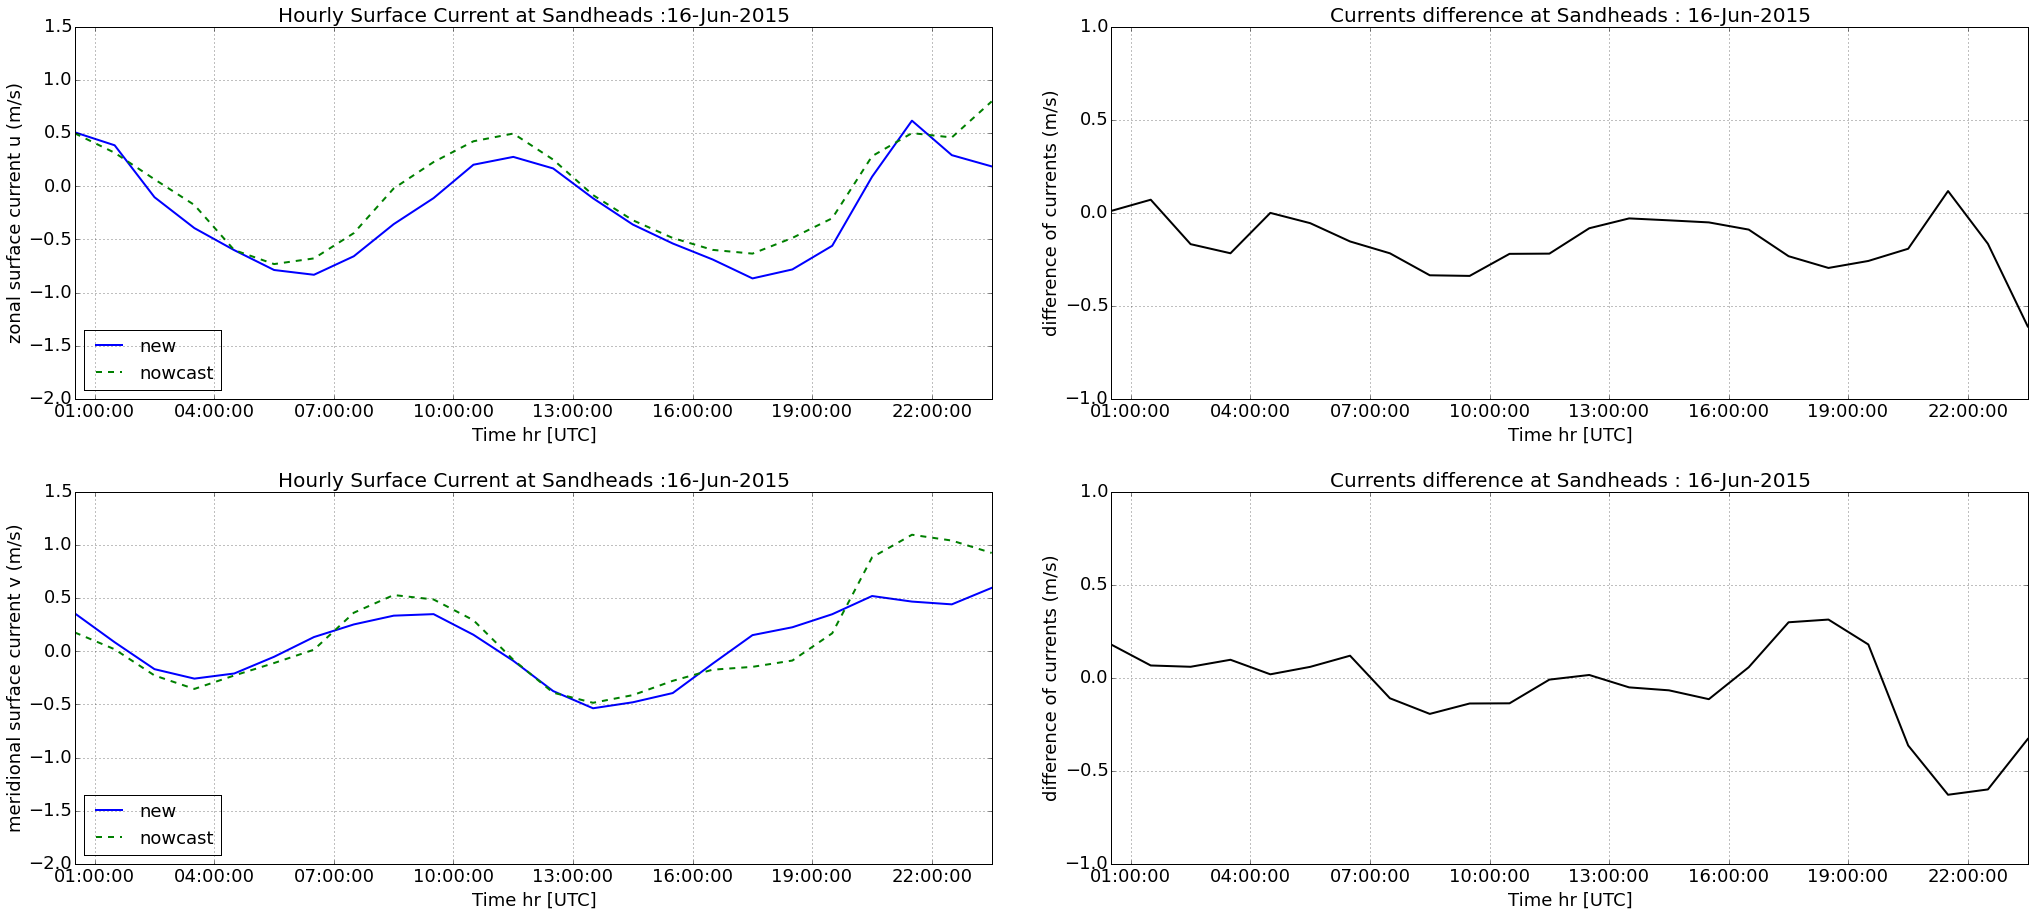

In [18]:
fig = compare_surfacecurrent_new(grid_T_16,0, u_16new, v_16new, u_16now, v_16now)

* For June 17

In [29]:
grid_T_17 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/17jun15/SalishSea_1h_20150617_20150617_grid_T.nc')

In [30]:
grid_U_new17 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150617_20150617_grid_U.nc')
grid_V_new17 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150617_20150617_grid_V.nc')

In [31]:
u_17new = grid_U_new17.variables['vozocrtx']
v_17new = grid_V_new17.variables['vomecrty']

In [33]:
grid_U_17 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/17jun15/SalishSea_1h_20150617_20150617_grid_U.nc')
grid_V_17 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/17jun15/SalishSea_1h_20150617_20150617_grid_V.nc')

In [34]:
u_17now = grid_U_17.variables['vozocrtx']
v_17now = grid_V_17.variables['vomecrty']

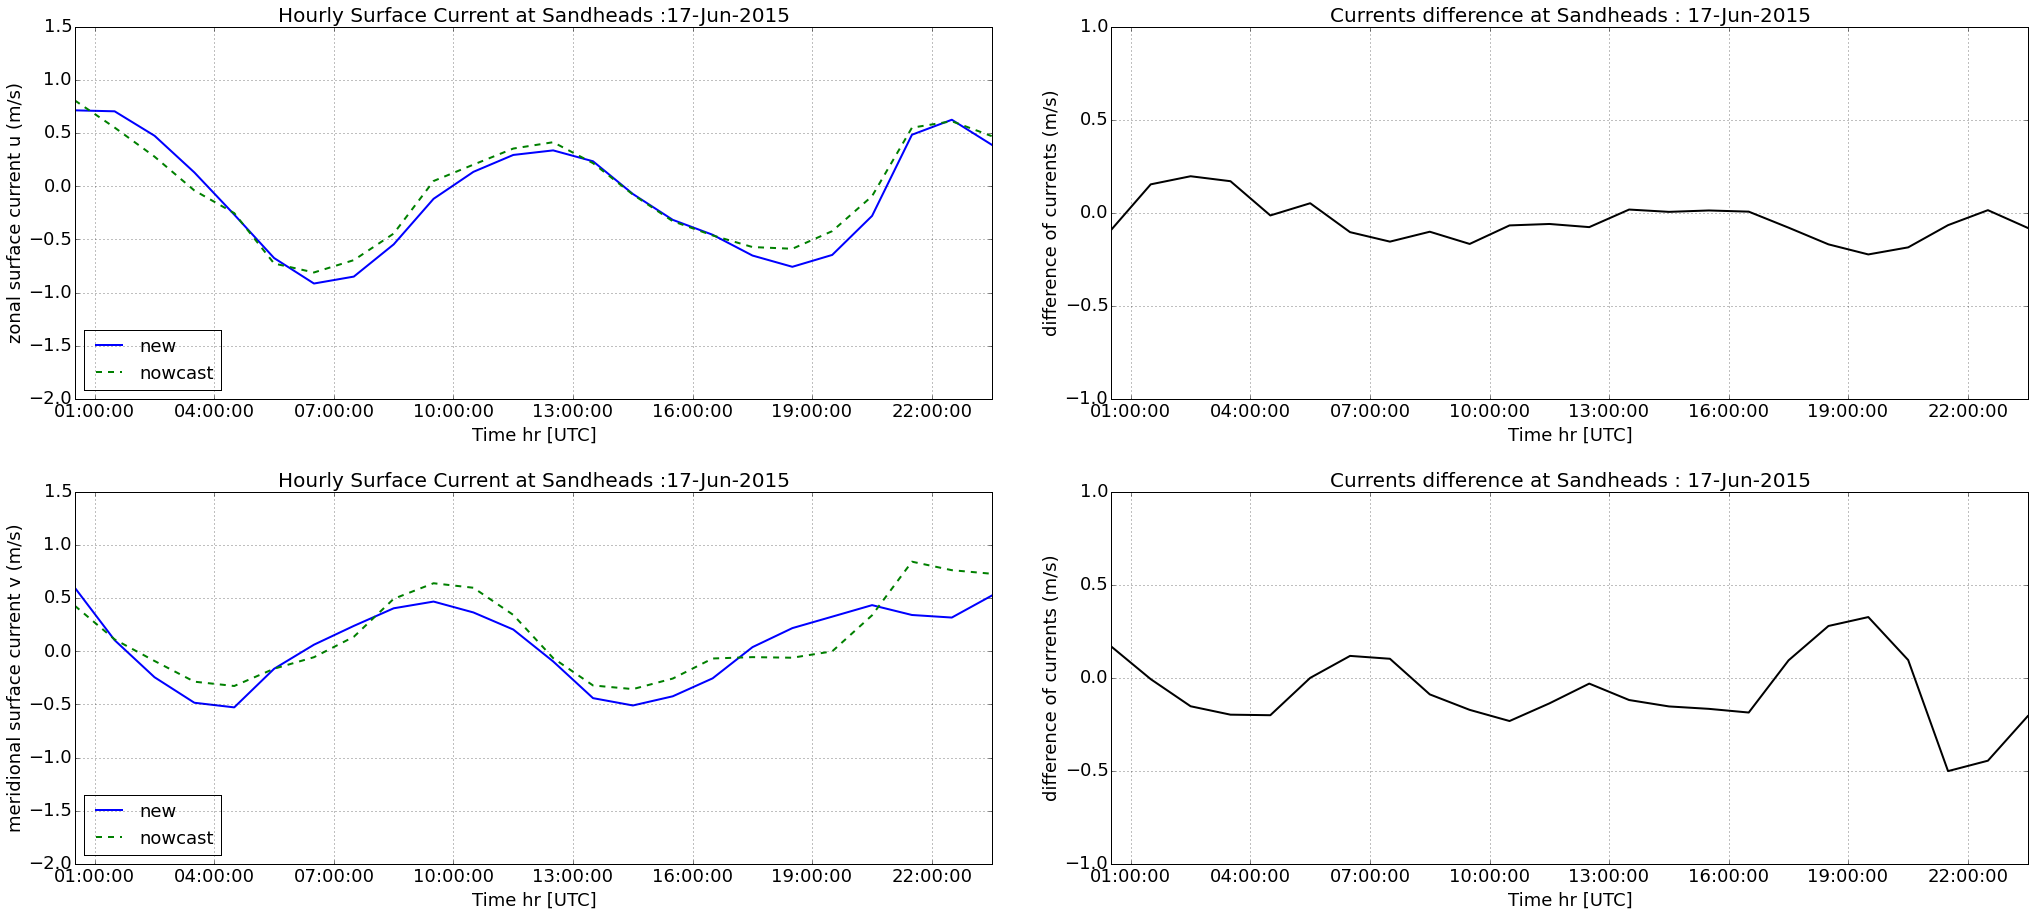

In [35]:
fig = compare_surfacecurrent_new(grid_T_17,0, u_17new, v_17new, u_17now, v_17now)

* For June 18

In [36]:
grid_T_18 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/18jun15/SalishSea_1h_20150618_20150618_grid_T.nc')
grid_U_new18 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150618_20150618_grid_U.nc')
grid_V_new18 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150618_20150618_grid_V.nc')
u_18new = grid_U_new18.variables['vozocrtx']
v_18new = grid_V_new18.variables['vomecrty']
grid_U_18 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/18jun15/SalishSea_1h_20150618_20150618_grid_U.nc')
grid_V_18 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/18jun15/SalishSea_1h_20150618_20150618_grid_V.nc')
u_18now = grid_U_18.variables['vozocrtx']
v_18now = grid_V_18.variables['vomecrty']

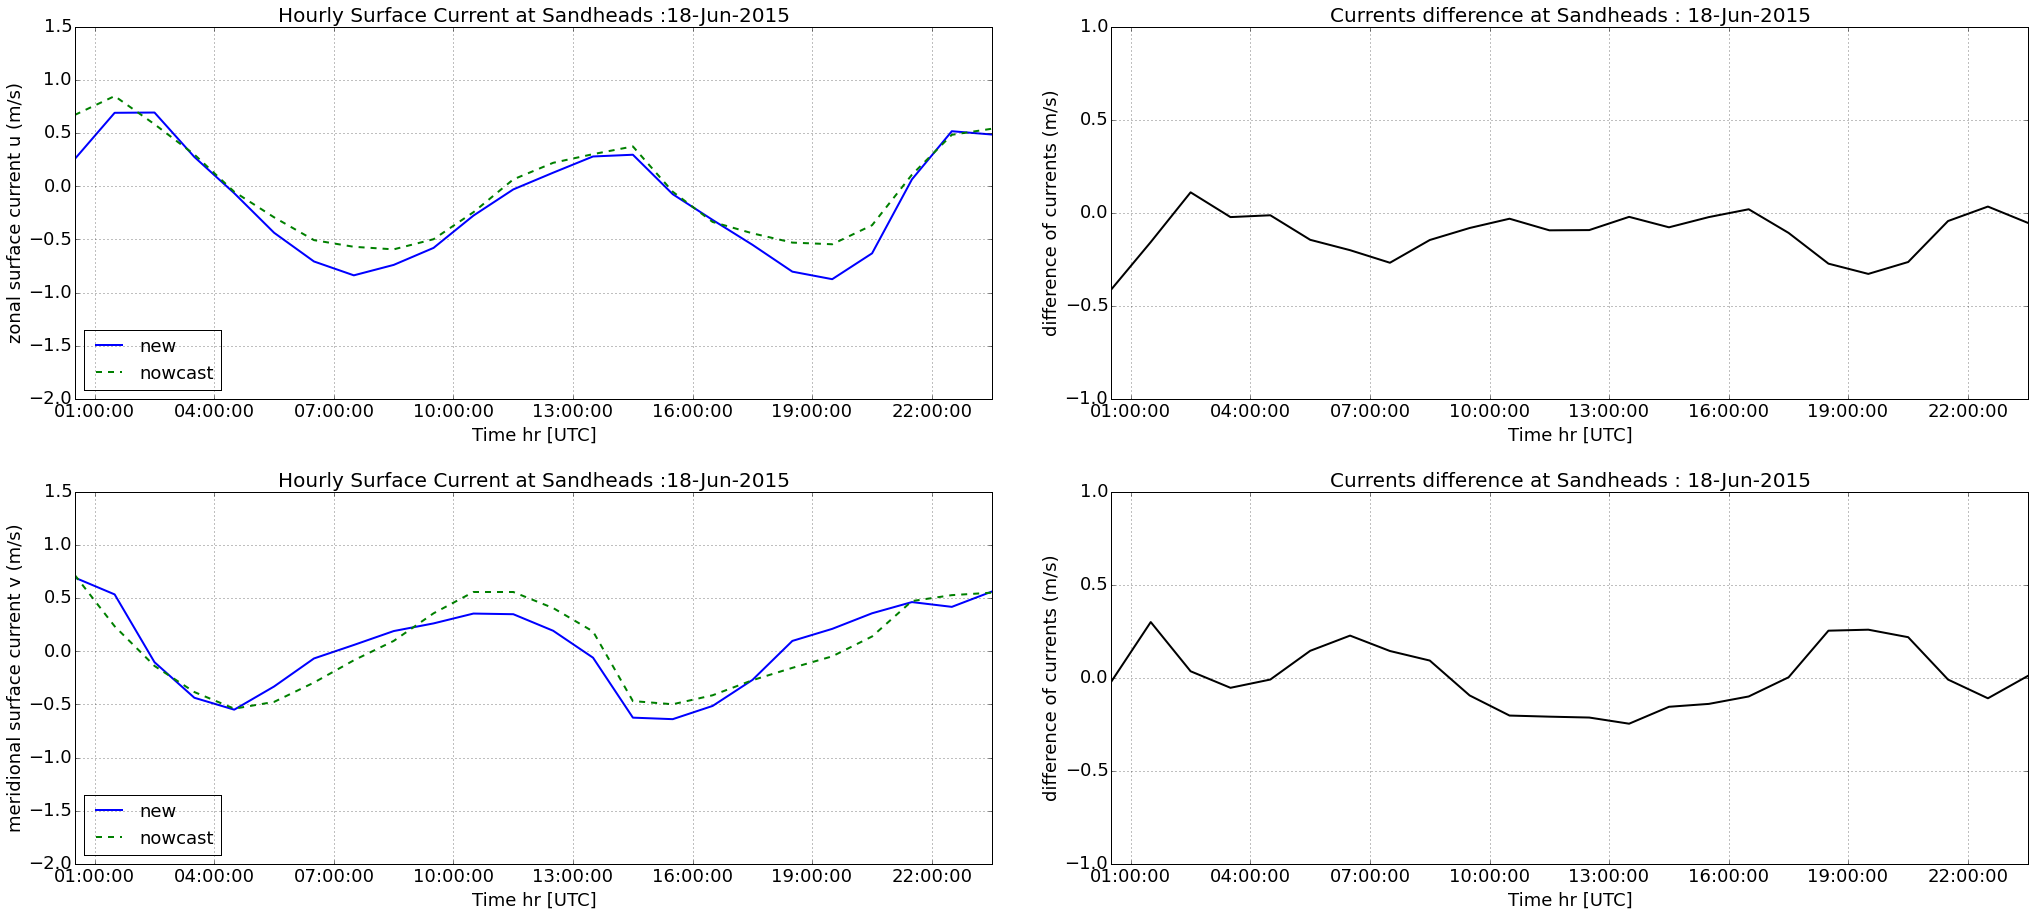

In [37]:
fig = compare_surfacecurrent_new(grid_T_18,0, u_18new, v_18new, u_18now, v_18now)

* For June 19

In [38]:
grid_T_19 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/19jun15/SalishSea_1h_20150619_20150619_grid_T.nc')
grid_U_new19 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150619_20150619_grid_U.nc')
grid_V_new19 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150619_20150619_grid_V.nc')
u_19new = grid_U_new19.variables['vozocrtx']
v_19new = grid_V_new19.variables['vomecrty']
grid_U_19 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/19jun15/SalishSea_1h_20150619_20150619_grid_U.nc')
grid_V_19 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/19jun15/SalishSea_1h_20150619_20150619_grid_V.nc')
u_19now = grid_U_19.variables['vozocrtx']
v_19now = grid_V_19.variables['vomecrty']

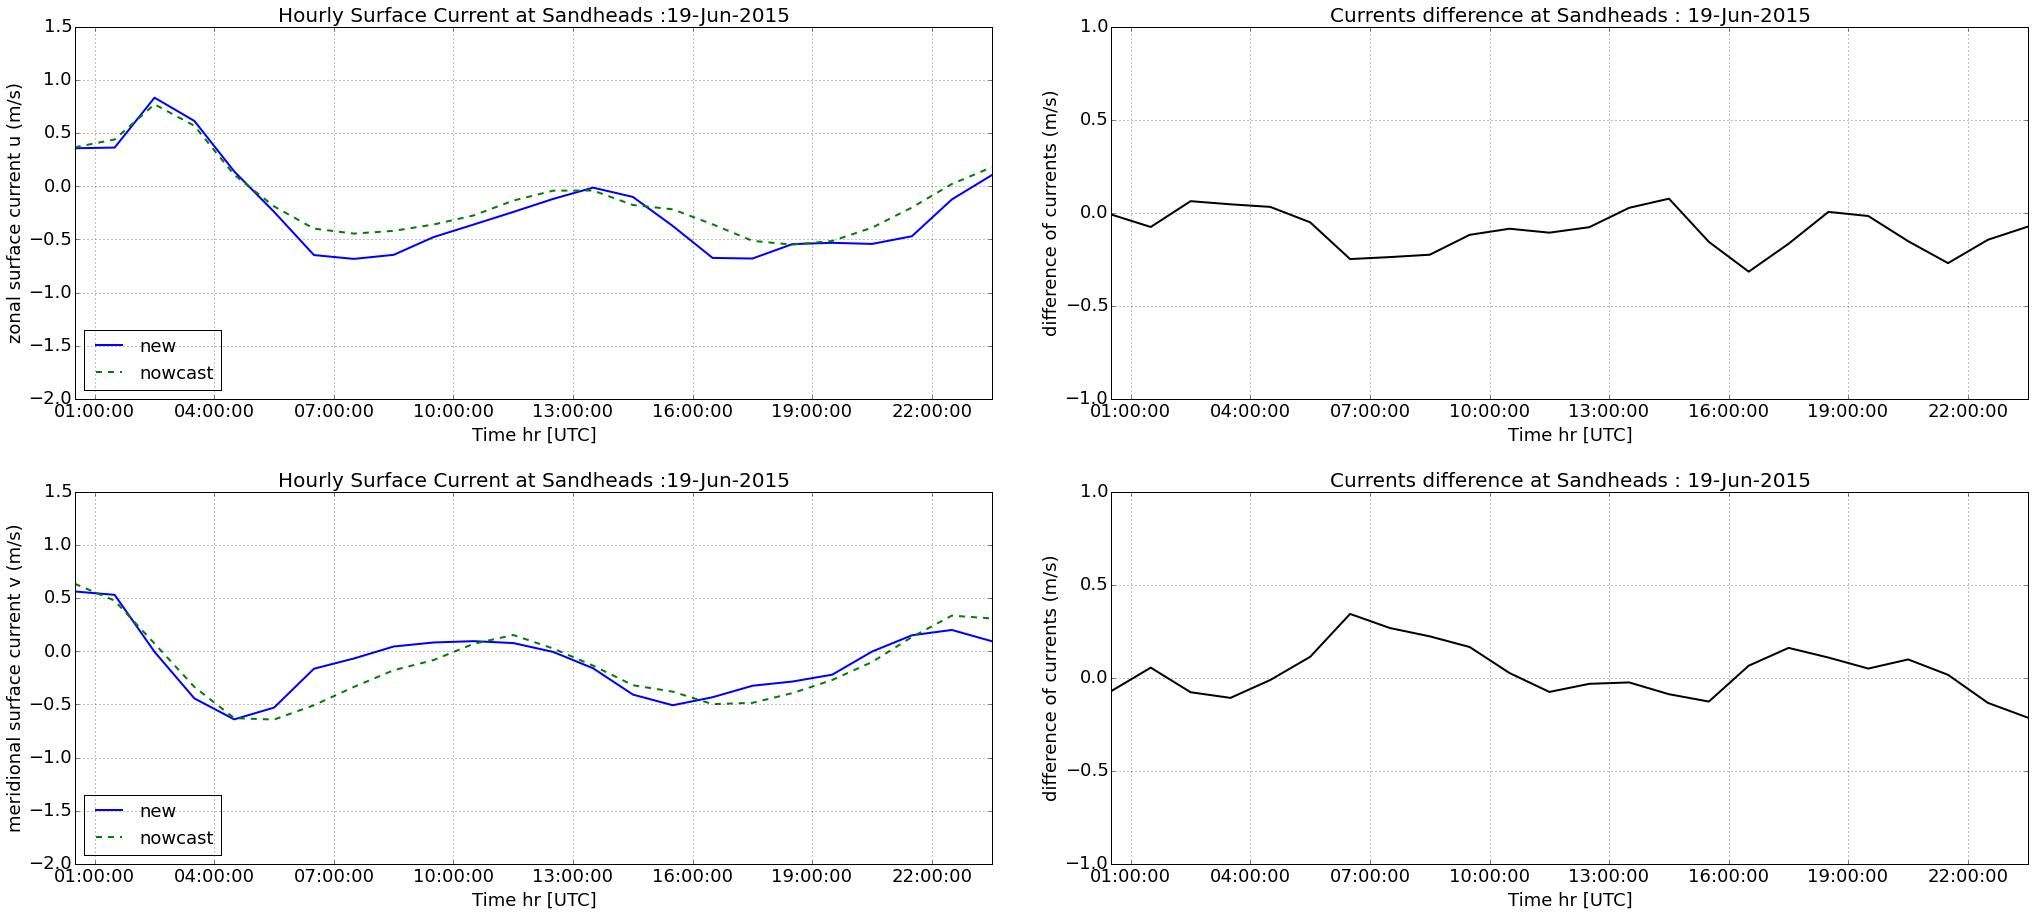

In [39]:
fig = compare_surfacecurrent_new(grid_T_19,0, u_19new, v_19new, u_19now, v_19now)

* For June 20

In [40]:
grid_T_20 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/20jun15/SalishSea_1h_20150620_20150620_grid_T.nc')
grid_U_new20 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150620_20150620_grid_U.nc')
grid_V_new20 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150620_20150620_grid_V.nc')
u_20new = grid_U_new20.variables['vozocrtx']
v_20new = grid_V_new20.variables['vomecrty']
grid_U_20 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/20jun15/SalishSea_1h_20150620_20150620_grid_U.nc')
grid_V_20 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/20jun15/SalishSea_1h_20150620_20150620_grid_V.nc')
u_20now = grid_U_20.variables['vozocrtx']
v_20now = grid_V_20.variables['vomecrty']

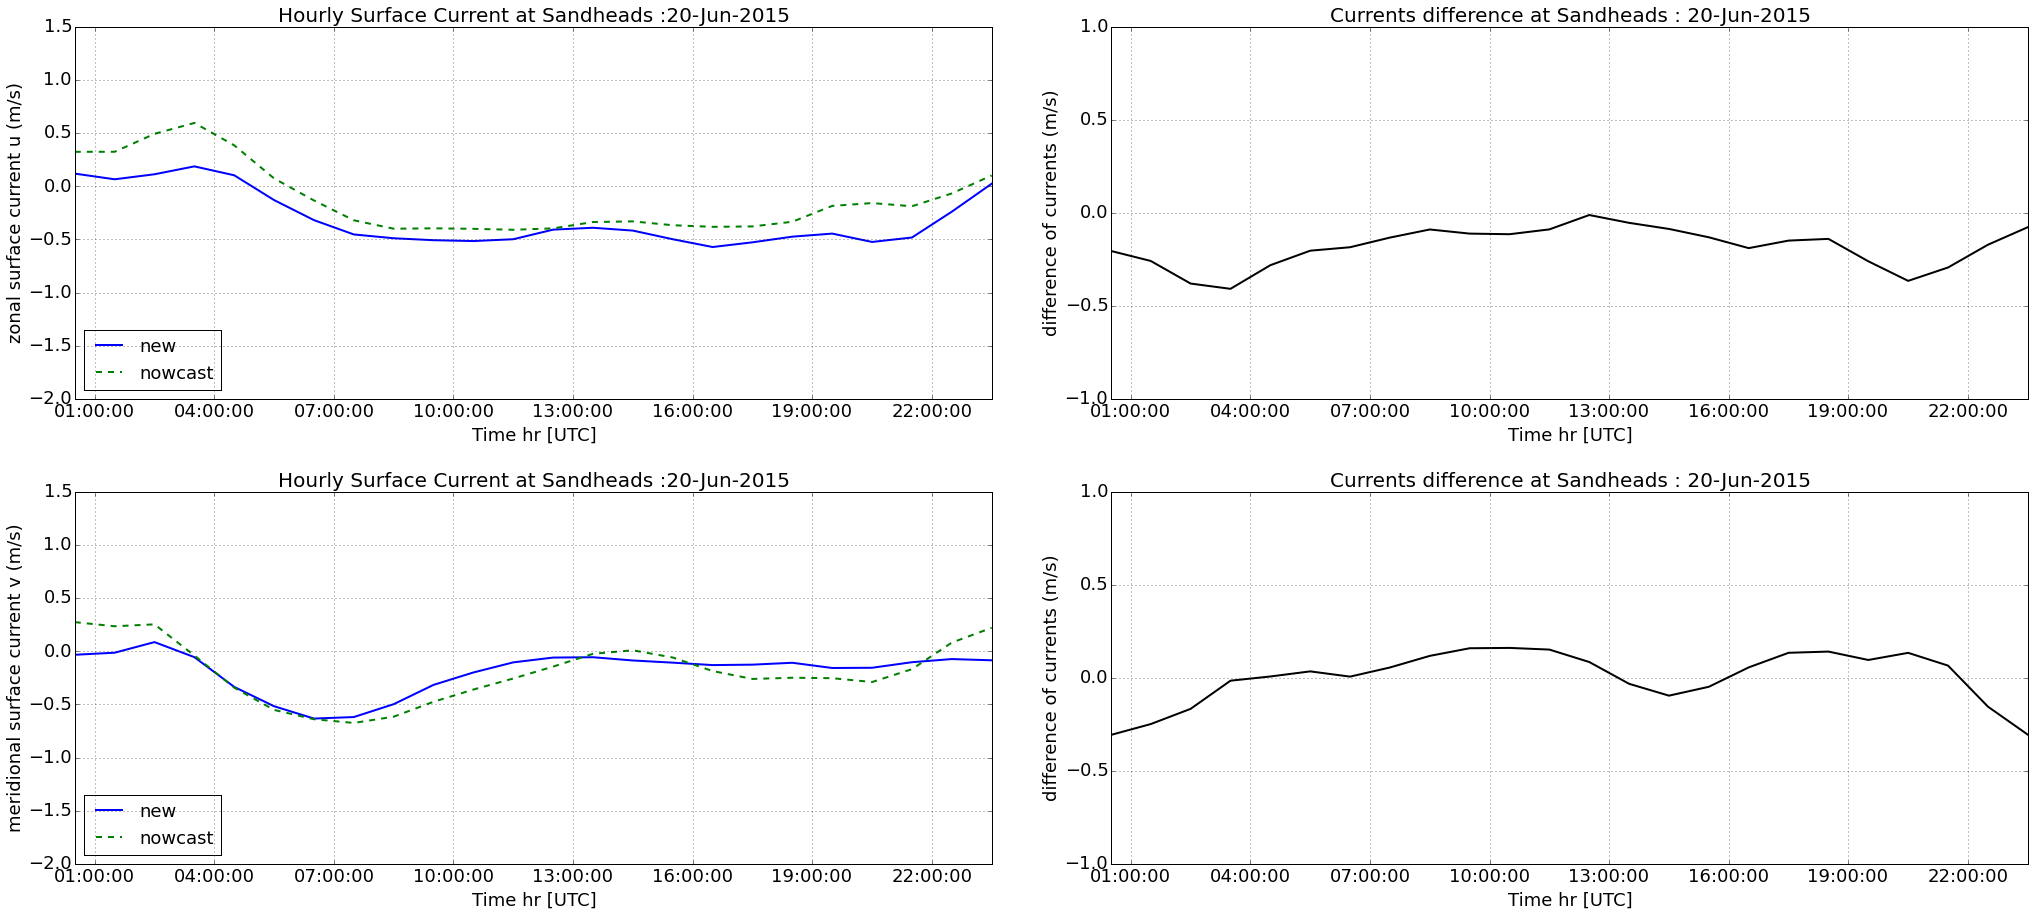

In [41]:
fig = compare_surfacecurrent_new(grid_T_20,0, u_20new, v_20new, u_20now, v_20now)

* For June 21

In [42]:
grid_T_21 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/21jun15/SalishSea_1h_20150621_20150621_grid_T.nc')
grid_U_new21 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150621_20150621_grid_U.nc')
grid_V_new21 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150621_20150621_grid_V.nc')
u_21new = grid_U_new21.variables['vozocrtx']
v_21new = grid_V_new21.variables['vomecrty']
grid_U_21 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/21jun15/SalishSea_1h_20150621_20150621_grid_U.nc')
grid_V_21 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/21jun15/SalishSea_1h_20150621_20150621_grid_V.nc')
u_21now = grid_U_21.variables['vozocrtx']
v_21now = grid_V_21.variables['vomecrty']

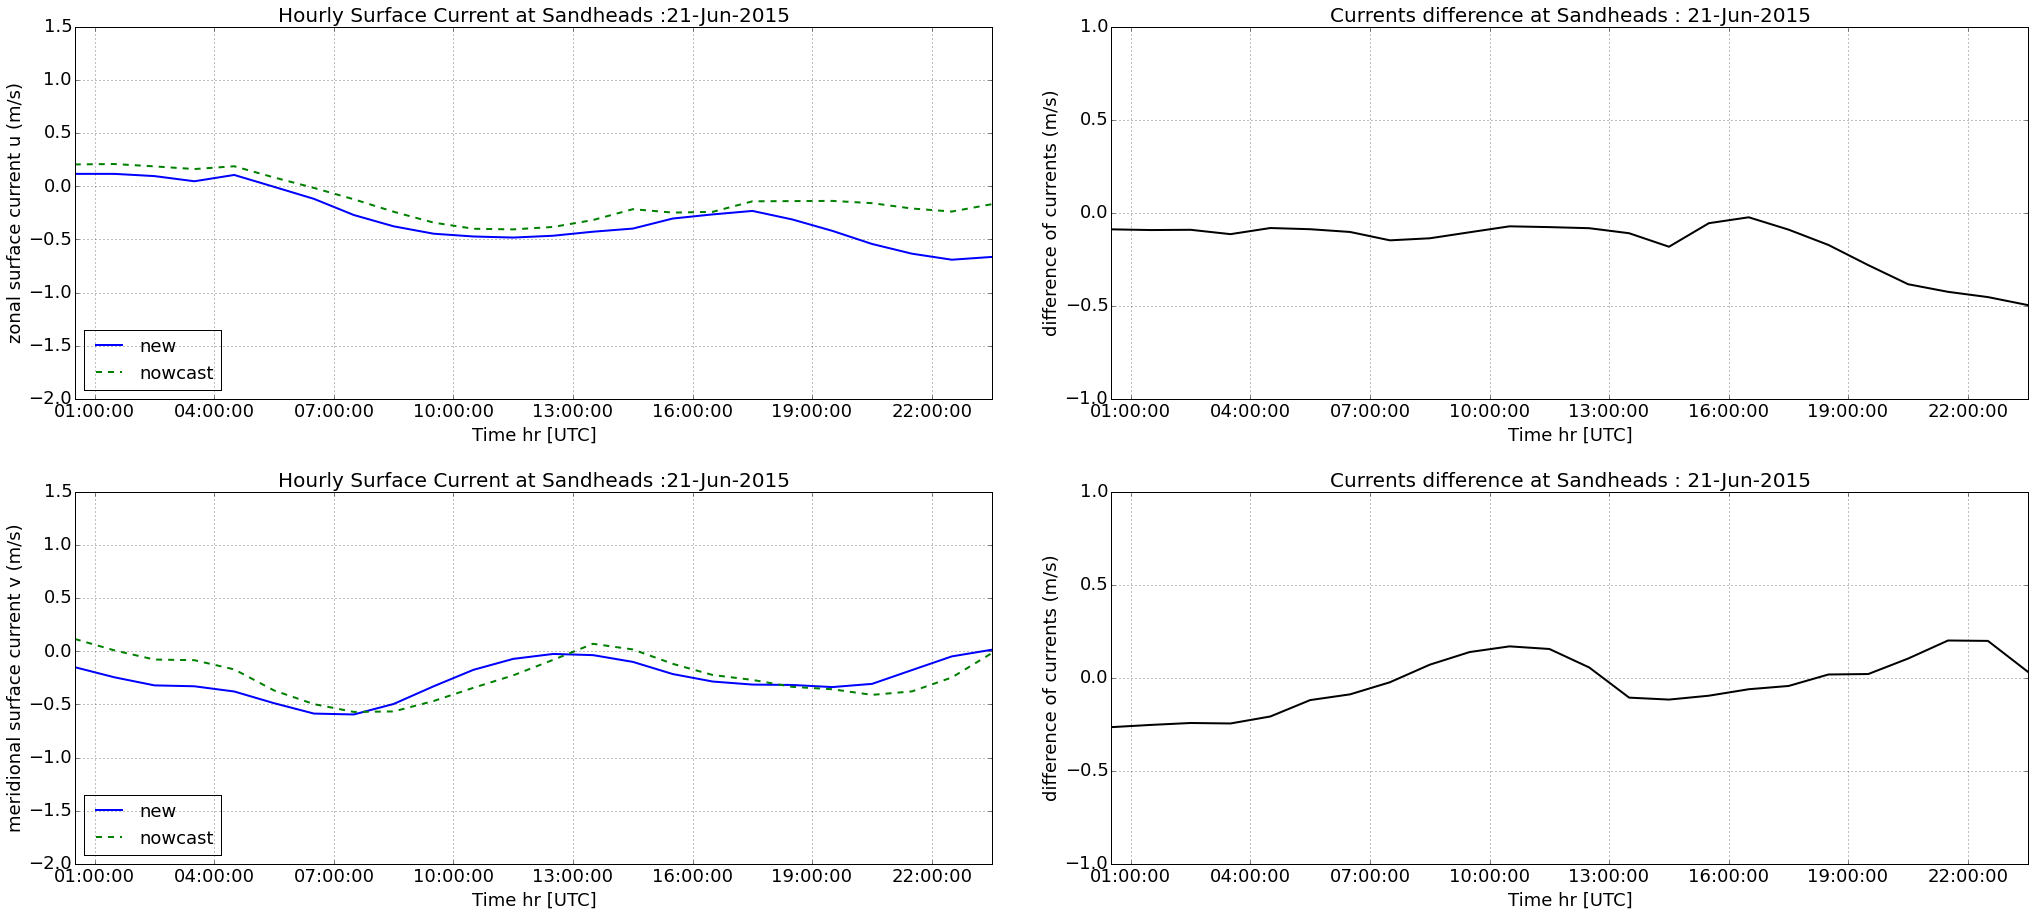

In [43]:
fig = compare_surfacecurrent_new(grid_T_21,0, u_21new, v_21new, u_21now, v_21now)

* For June22

In [44]:
grid_T_22 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/22jun15/SalishSea_1h_20150622_20150622_grid_T.nc')
grid_U_new22 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150622_20150622_grid_U.nc')
grid_V_new22 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150622_20150622_grid_V.nc')
u_22new = grid_U_new22.variables['vozocrtx']
v_22new = grid_V_new22.variables['vomecrty']
grid_U_22 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/22jun15/SalishSea_1h_20150622_20150622_grid_U.nc')
grid_V_22 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/22jun15/SalishSea_1h_20150622_20150622_grid_V.nc')
u_22now = grid_U_22.variables['vozocrtx']
v_22now = grid_V_22.variables['vomecrty']

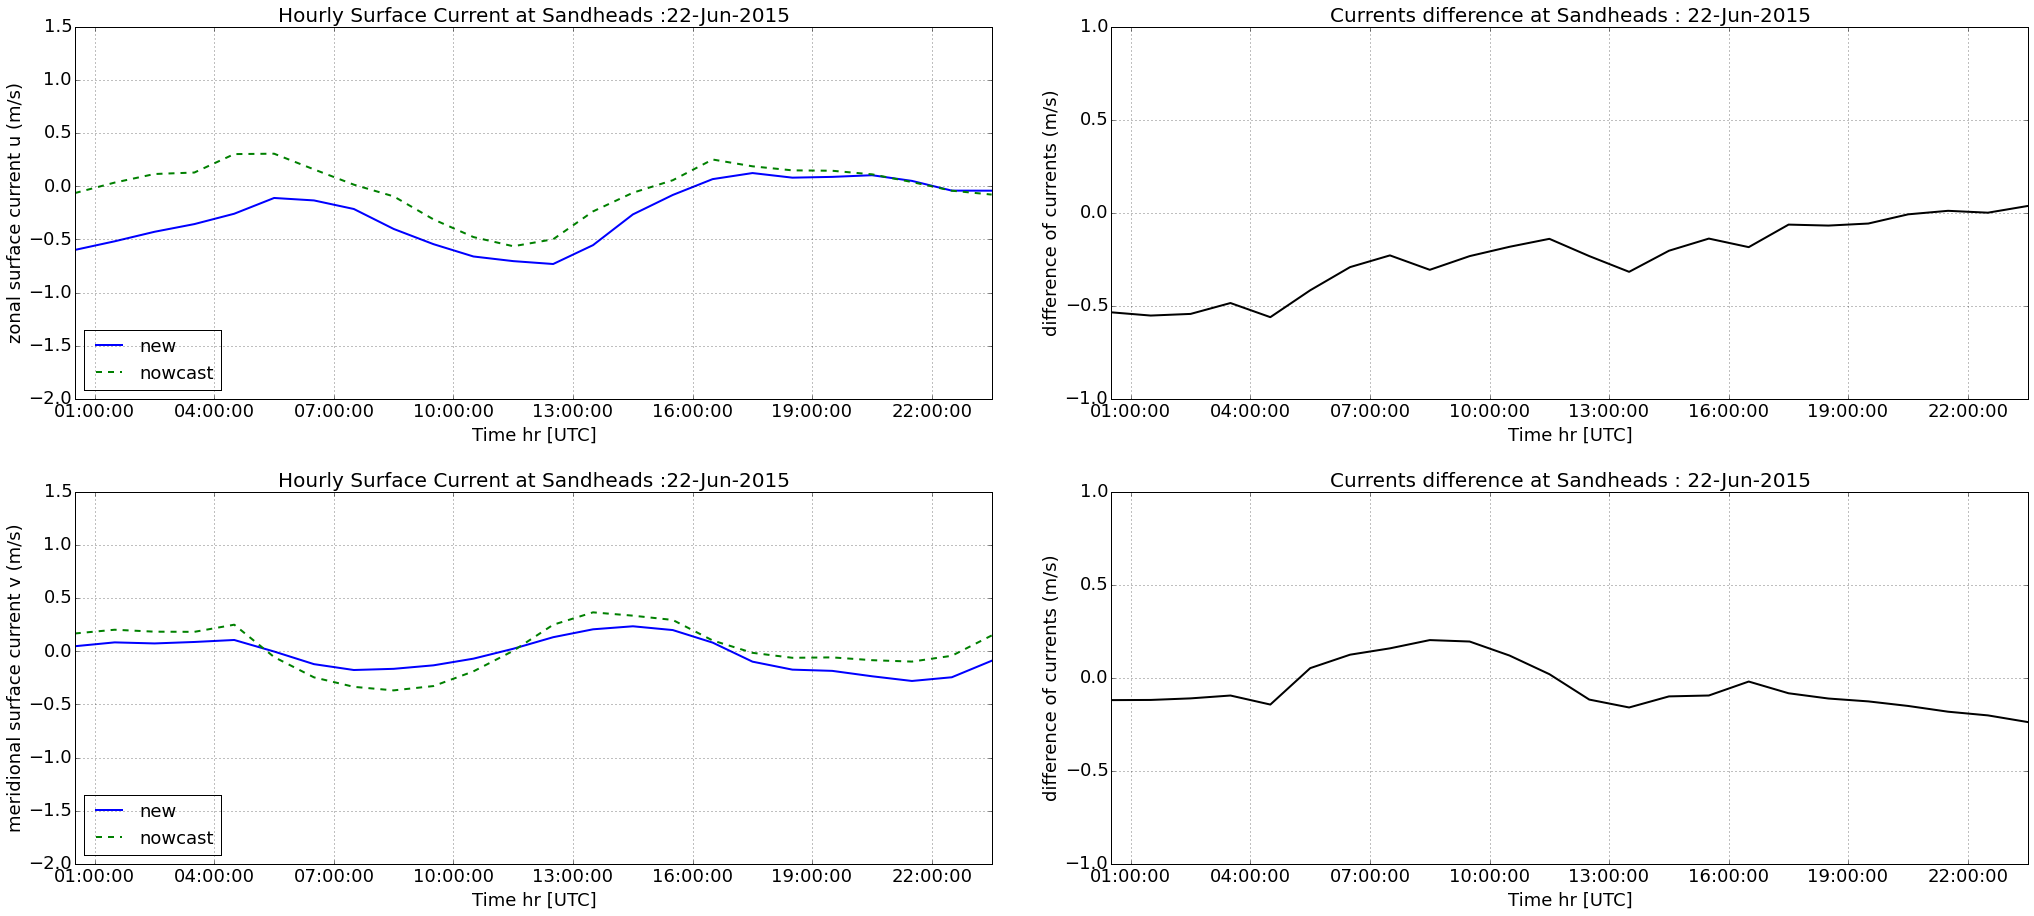

In [45]:
fig = compare_surfacecurrent_new(grid_T_22,0, u_22new, v_22new, u_22now, v_22now)

* For June 23

In [46]:
grid_T_23 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/23jun15/SalishSea_1h_20150623_20150623_grid_T.nc')
grid_U_new23 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150623_20150623_grid_U.nc')
grid_V_new23 = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NW/1hplume_20150623_20150623_grid_V.nc')
u_23new = grid_U_new23.variables['vozocrtx']
v_23new = grid_V_new23.variables['vomecrty']
grid_U_23 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/23jun15/SalishSea_1h_20150623_20150623_grid_U.nc')
grid_V_23 = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/23jun15/SalishSea_1h_20150623_20150623_grid_V.nc')
u_23now = grid_U_23.variables['vozocrtx']
v_23now = grid_V_23.variables['vomecrty']

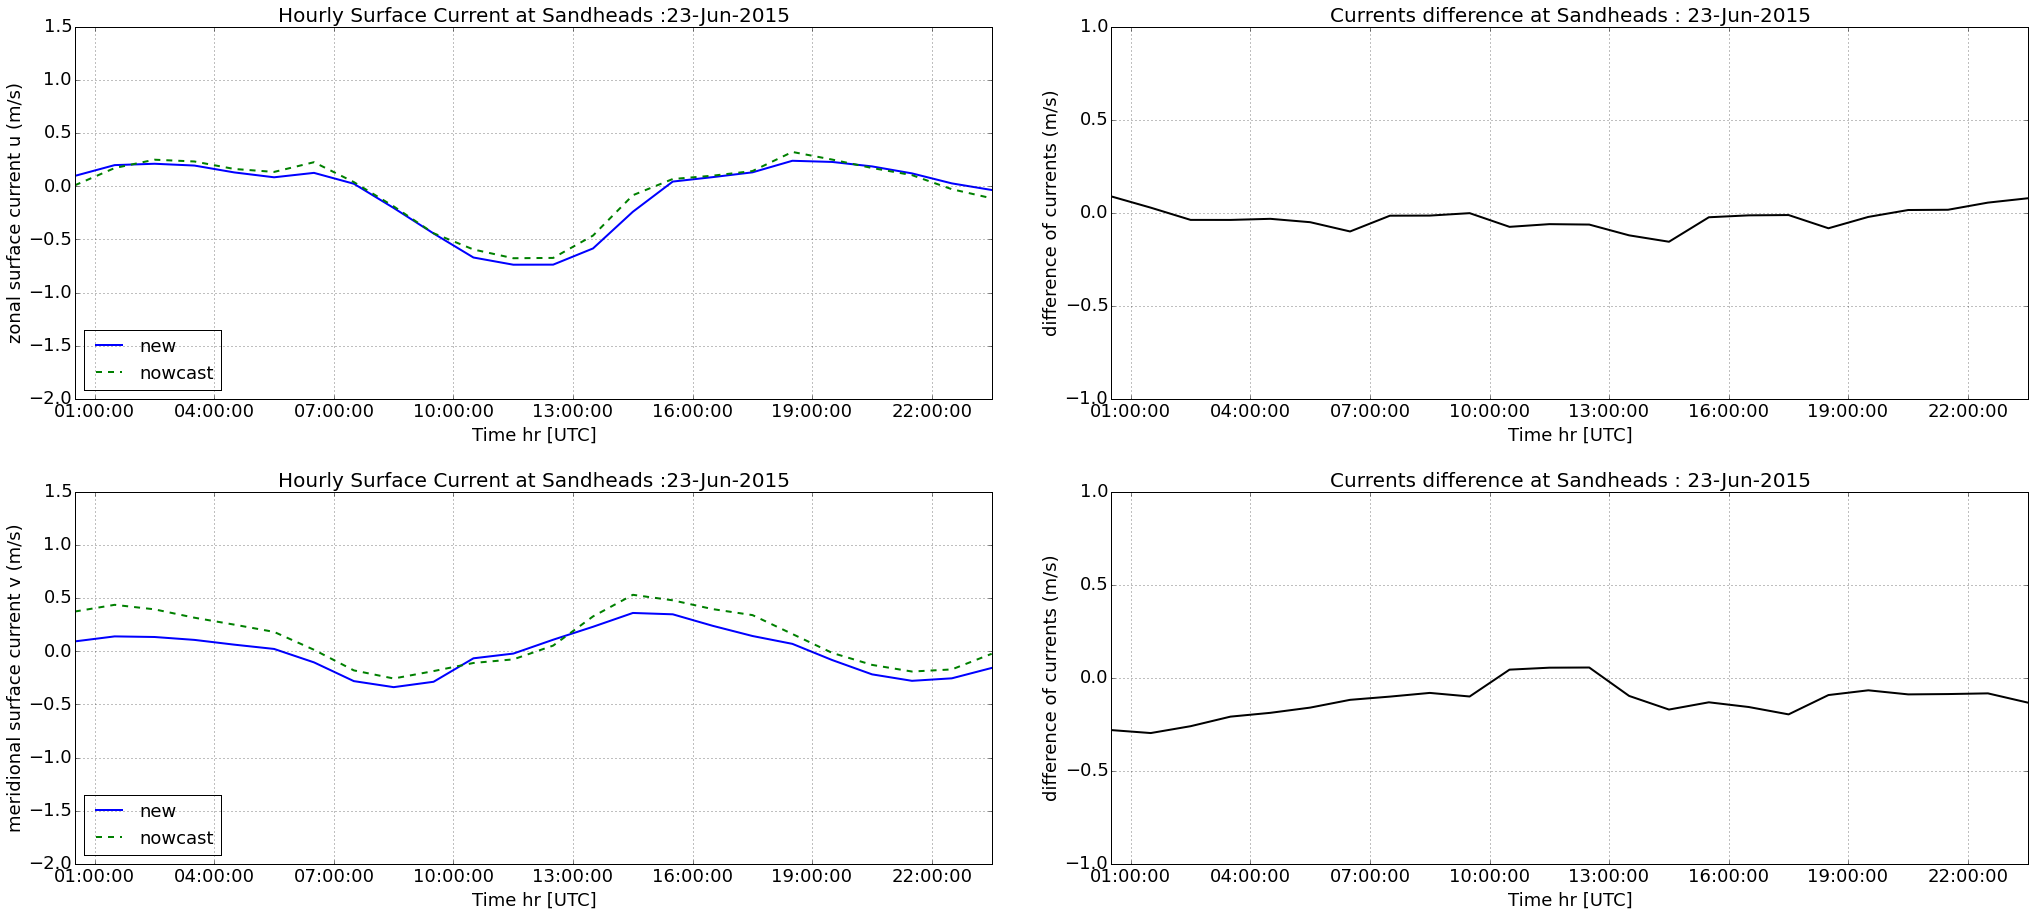

In [47]:
fig = compare_surfacecurrent_new(grid_T_23,0, u_23new, v_23new, u_23now, v_23now)